In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Utils.properties import HAC
from Utils.mapper import mapper
from pathos.multiprocessing import ProcessingPool as Pool
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolDrawOptions
from rdkit.Chem import Draw
import cairosvg
import xml.etree.ElementTree as ET
from Utils.smiles import murcko_scaffold

/home/chaoting/software/miniconda3/envs/py385/lib/python3.8/site-packages/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mcf.append(_pains, sort=True)['smarts'].values]


In [68]:
def add_hac(df):
    mols = list(map(MolFromSmiles, df['scaffold']))
    df['HAC'] = list(map(HAC, mols))
    return df

def plot_highlighted_smiles_group(
        smiles,
        substructure_smiles,
        save_path,
        img_size,
        n_per_mol=None,
        n_jobs=1,
        highlight_color=(0, 1, 0),
        descriptions=None
    ):
    substructure = Chem.MolFromSmiles(substructure_smiles)
    molecules = list(map(Chem.MolFromSmiles, smiles))
        
    print(len(molecules))
        
    for mol in molecules:
        rdDepictor.Compute2DCoords(mol)

    highlights = []
    for mol in molecules:
        match = mol.GetSubstructMatch(substructure)
        atom_highlights = set(match)
        bond_highlights = set()
        for atom_idx in match:
            atom_bonds = mol.GetAtomWithIdx(atom_idx).GetBonds()
            for bond in atom_bonds:
                if bond.GetBeginAtomIdx() in match and bond.GetEndAtomIdx() in match:
                    bond_highlights.add(bond.GetIdx())
        highlights.append((atom_highlights, bond_highlights))

    # Create a custom MolDrawOptions object
    draw_options = MolDrawOptions()
    draw_options.highlightColour = highlight_color
    draw_options.legendFontSize = 20

    img = Draw.MolsToGridImage(molecules, molsPerRow=n_per_mol, subImgSize=img_size,
                                highlightAtomLists=[hl_atoms for hl_atoms, _ in highlights],
                                highlightBondLists=[hl_bonds for _, hl_bonds in highlights],
                                drawOptions=draw_options, returnPNG=False,
                                legends=descriptions
                                )

    # img = Draw.MolsToGridImage(molecules, molsPerRow=n_per_mol, subImgSize=img_size,
    #                             highlightAtomLists=[hl_atoms for hl_atoms, _ in highlights],
    #                             highlightBondLists=[hl_bonds for _, hl_bonds in highlights],
    #                             drawOptions=draw_options, useSVG=True,
    #                             legends=descriptions
    #                             )

    img.save(save_path)

    # root = ET.fromstring(img)
    # width = int(root.attrib['width'].strip('px'))
    # height = int(root.attrib['height'].strip('px'))

    # png_data = cairosvg.svg2png(bytestring=img,
    #                             output_width=width*1.6,
    #                             output_height=height*1.6)
    
    # with open(save_path, 'wb') as f:
    #     f.write(png_data)

### HAC distribution of seen and unseen scaffolds

In [4]:
file_folder = "/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/"
train = pd.read_csv(os.path.join(file_folder, 'train_sample.csv'), index_col=[0])
test_scaffold = pd.read_csv(os.path.join(file_folder, 'test_scaffolds_sample.csv'), index_col=[0])

In [4]:

column1 = 'Seen scaffolds'
column2 = 'Unseen scaffolds'

mols = list(map(MolFromSmiles, train['scaffold']))
hac1 = list(map(HAC, mols))
mols = list(map(MolFromSmiles, test_scaffold['scaffold']))
hac2 = list(map(HAC, mols))

df = pd.DataFrame({ column1: hac1, column2: hac2 })
df

NameError: name 'train' is not defined

In [6]:
test_scaffold['HAC'] = hac2
print(test_scaffold[test_scaffold.HAC == 9])

           scaffold  n_train  HAC
67  c1ccc2c(c1)CCS2        0    9


,scaffold,n_train,HAC,test_scaffold - HAC


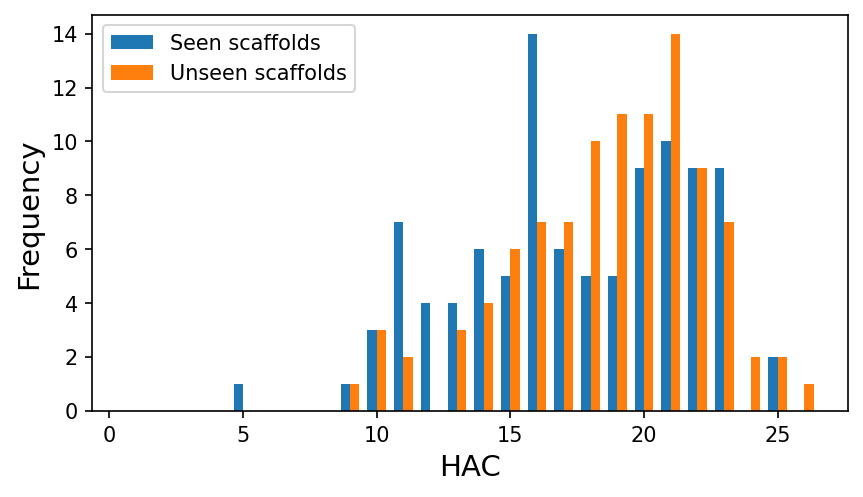

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_chart_from_dataframe(df, column1, column2, x_label, y_label):
    freq1 = df[column1].value_counts()
    freq1 = freq1.sort_index()
    freq2 = df[column2].value_counts()
    freq2 = freq2.sort_index()
    
    max_val = max(freq1.index.max(), freq2.index.max())
    freq1 = freq1.reindex(np.arange(1, max_val+1), fill_value=0)
    freq2 = freq2.reindex(np.arange(1, max_val+1), fill_value=0)

    # Create a bar chart
    x_values = freq1.index
    width = 0.35

    fig, ax = plt.subplots(figsize=(6.5, 3.5), dpi=150)
    rects1 = ax.bar(x_values - width/2, freq1, width, label=column1)
    rects2 = ax.bar(x_values + width/2, freq2, width, label=column2)

    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.legend()

    plt.show()
    

plot_bar_chart_from_dataframe(df, column1, column2, 
                              x_label='HAC',
                              y_label='Frequency')

### # Unique vs. Frequency in train

In [3]:
met1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf1-warmup15000-15/train/metric.csv')
met2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf2-warmup15000-16/train/metric.csv')
met3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf3-warmup15000-16/train/metric.csv')

In [4]:
n_unique_ssf = (met1['n_unique_ssf'] + met2['n_unique_ssf'] + met3['n_unique_ssf']) / 3

In [5]:
train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])
freq_in_train = np.array([len(train[train.scaffold == sca]) for sca in met1['scaffold']])

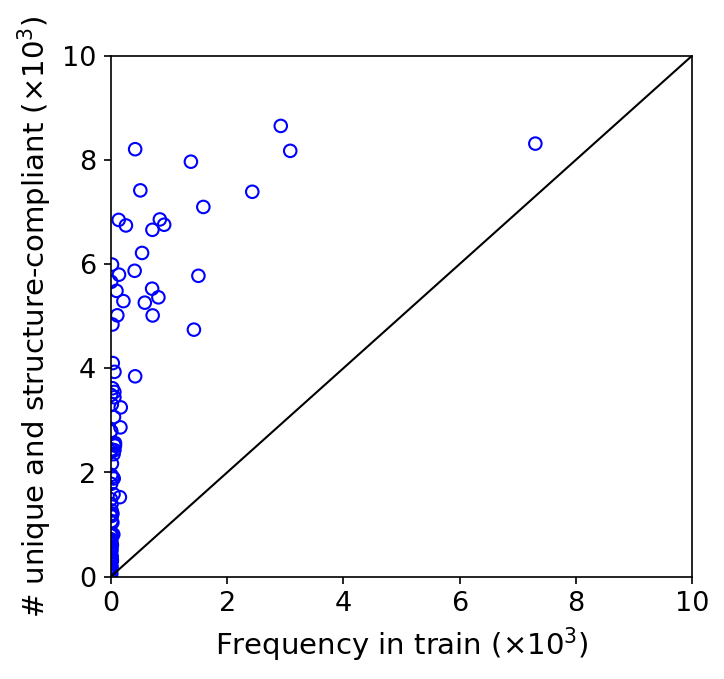

In [19]:
x = freq_in_train / 1000
y = n_unique_ssf / 1000

xlabel = r'Frequency in train ($\times 10^3$)'
ylabel = r'# unique and structure-compliant ($\times 10^3$)'

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='blue')
plt.plot([0, 10], [0, 10], color='black', linewidth=1)

plt.xlabel(xlabel, fontsize=14)
plt.ylabel(ylabel, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim((0, 10))
plt.ylim((0, 10))

# plt.legend(fontsize=10
plt.show()

In [10]:
x = freq_in_train / 1000
y = n_unique / 1000

xlabel = r'Frequency in train ($10^3$)'
ylabel = r'# unique ($10^3$)'

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='blue')
plt.plot([0, 10], [0, 10], color='black', linewidth=1)

plt.xlabel(xlabel, fontsize=16)
plt.ylabel(ylabel, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim((0, 10))
plt.ylim((0, 10))

# plt.legend(fontsize=10
plt.show()

NameError: name 'n_unique' is not defined

### Metric value (unique, intDiv) vs. HAC of the scaffold

In [14]:
met1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf1-warmup15000-15/train/metric.csv', index_col=[0])
met2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf2-warmup15000-16/train/metric.csv', index_col=[0])
met3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf3-warmup15000-16/train/metric.csv', index_col=[0])

met4 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf1-warmup15000-15/test_scaffolds/metric.csv', index_col=[0])
met5 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf2-warmup15000-16/test_scaffolds/metric.csv', index_col=[0])
met6 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf3-warmup15000-16/test_scaffolds/metric.csv', index_col=[0])

In [15]:
met1 = add_hac(met1)
met2 = add_hac(met2)
met3 = add_hac(met3)

met4 = add_hac(met4)
met5 = add_hac(met5)
met6 = add_hac(met6)

In [38]:
met_seen = pd.concat([met1, met2, met3]).groupby('scaffold').mean().reset_index()
met_unseen = pd.concat([met4, met5, met6]).groupby('scaffold').mean().reset_index()

In [39]:
met_seen.mean()

<ipython-input-39-4f5afd3ca6a9>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  met_seen.mean()


valid                     0.989739
unique                    0.302585
novel                     0.972828
intDiv                    0.661582
sim                       0.986587
SSF                       0.964426
sim80                     0.971089
n_valid                9897.393333
n_unique               2990.080000
n_novel                2869.026667
n_SSF                  9550.713333
n_sim80                9616.536667
n_unique_ssf           2780.913333
valid_in_tolerance     9549.456667
unique_in_tolerance    2780.100000
HAC                      17.360000
dtype: float64

In [41]:
met_unseen.mean()

<ipython-input-41-d2fc704ed20a>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  met_unseen.mean()


valid                     0.989961
unique                    0.243343
novel                     0.997382
intDiv                    0.638210
sim                       0.975056
SSF                       0.936994
sim80                     0.950739
n_valid                9899.606667
n_unique               2402.313333
n_novel                2397.646667
n_SSF                  9291.103333
n_sim80                9418.490000
n_unique_ssf           2054.140000
valid_in_tolerance     9282.226667
unique_in_tolerance    2051.076667
HAC                      18.630000
dtype: float64

In [22]:
met_seen.columns

Index(['scaffold', 'valid', 'unique', 'novel', 'intDiv', 'sim', 'SSF', 'sim80',
       'n_valid', 'n_unique', 'n_novel', 'n_SSF', 'n_sim80', 'n_unique_ssf',
       'valid_in_tolerance', 'unique_in_tolerance', 'HAC'],
      dtype='object')

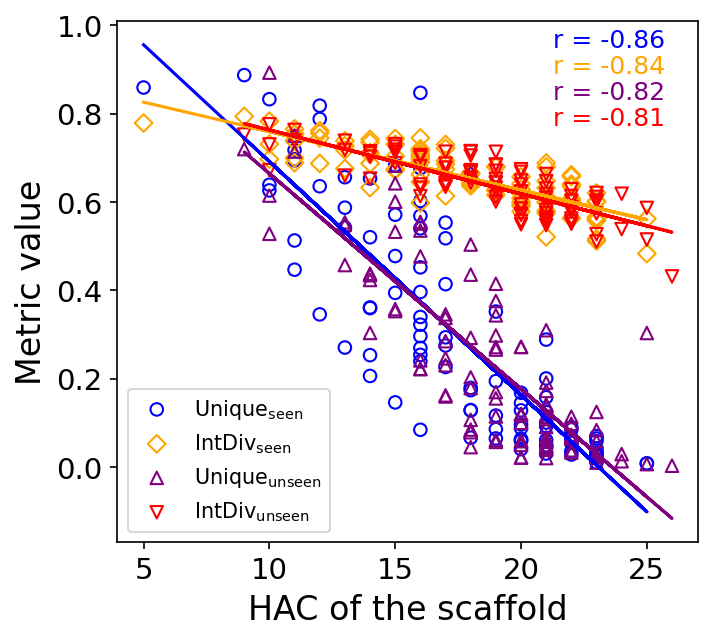

In [30]:
# import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False

unique1 = met_seen['unique']
unique2 = met_unseen['unique']
intdiv1 = met_seen['intDiv']
intdiv2 = met_unseen['intDiv']
hac1 = met_seen['HAC']
hac2 = met_unseen['HAC']

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(hac1, unique1, label=r'$\mathdefault{Unique}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(hac1, intdiv1, label=r'$\mathdefault{IntDiv}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')
plt.scatter(hac2, unique2, label=r'$\mathdefault{Unique}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(hac2, intdiv2, label=r'$\mathdefault{IntDiv}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel('HAC of the scaffold', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(np.arange(0, 25+1, 5), fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower left')

m1, b1 = np.polyfit(hac1, unique1, deg=1)
m2, b2 = np.polyfit(hac1, intdiv1, deg=1)
plt.plot(hac1, m1*np.array(hac1) + b1, color='blue')
plt.plot(hac1, m2*np.array(hac1) + b2, color='orange')

m1, b1 = np.polyfit(hac2, unique2, deg=1)
m2, b2 = np.polyfit(hac2, intdiv2, deg=1)
plt.plot(hac2, m1*np.array(hac2) + b1, color='purple')
plt.plot(hac2, m2*np.array(hac2) + b2, color='red')


r1_unique = np.corrcoef(hac1, unique1)[0, 1]
r1_intdiv = np.corrcoef(hac1, intdiv1)[0, 1]
r2_unique = np.corrcoef(hac2, unique2)[0, 1]
r2_intdiv = np.corrcoef(hac2, intdiv2)[0, 1]

plt.text(0.75, 0.95, rf'r = {r1_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.text(0.75, 0.90, rf'r = {r1_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='orange')
plt.text(0.75, 0.85, rf'r = {r2_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='purple')
plt.text(0.75, 0.80, rf'r = {r2_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')


plt.show()

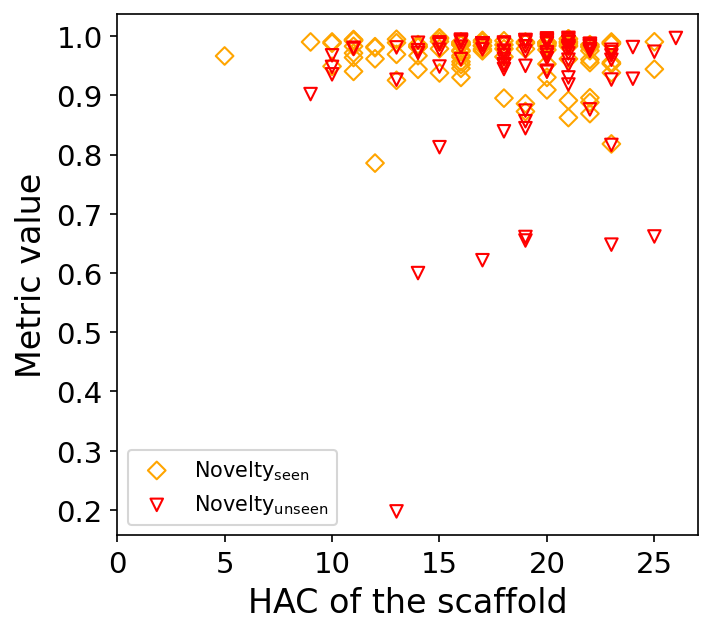

In [36]:
# import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False

valid1 = met_seen['valid']
valid2 = met_unseen['valid']
novel1 = met_seen['SSF']
novel2 = met_unseen['SSF']
hac1 = met_seen['HAC']
hac2 = met_unseen['HAC']

plt.figure(figsize=(5, 4.6), dpi=150)
# plt.scatter(hac1, valid1, label=r'$\mathdefault{Valid}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(hac1, novel1, label=r'$\mathdefault{Novelty}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')

# plt.scatter(hac2, valid2, label=r'$\mathdefault{Valid}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(hac2, novel2, label=r'$\mathdefault{Novelty}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel('HAC of the scaffold', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(np.arange(0, 25+1, 5), fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower left')

# m1, b1 = np.polyfit(hac1, unique1, deg=1)
# m2, b2 = np.polyfit(hac1, intdiv1, deg=1)
# plt.plot(hac1, m1*np.array(hac1) + b1, color='blue')
# plt.plot(hac1, m2*np.array(hac1) + b2, color='orange')

# m1, b1 = np.polyfit(hac2, unique2, deg=1)
# m2, b2 = np.polyfit(hac2, intdiv2, deg=1)
# plt.plot(hac2, m1*np.array(hac2) + b1, color='purple')
# plt.plot(hac2, m2*np.array(hac2) + b2, color='red')


# r1_unique = np.corrcoef(hac1, unique1)[0, 1]
# r1_intdiv = np.corrcoef(hac1, intdiv1)[0, 1]
# r2_unique = np.corrcoef(hac2, unique2)[0, 1]
# r2_intdiv = np.corrcoef(hac2, intdiv2)[0, 1]

# plt.text(0.75, 0.95, rf'r = {r1_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
# plt.text(0.75, 0.90, rf'r = {r1_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='orange')
# plt.text(0.75, 0.85, rf'r = {r2_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='purple')
# plt.text(0.75, 0.80, rf'r = {r2_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')


plt.show()

### unique, intDiv vs. # train

In [ ]:
def mol_from_smiles(smiles):
    return MolFromSmiles(smiles)

#### 計算 scaffold 在 train 的 frequency

In [ ]:
train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])
train = train.dropna(subset=['scaffold'])

In [ ]:
# # train = train[:2000]

# freq = train['scaffold'].value_counts()
# with Pool(n_jobs=16) as pool:
#     mols = pool.map(mol_from_smiles, freq.index)
# with Pool(n_jobs=16) as pool:
#     hac = pool.map(HAC, mols)
            
# df = pd.DataFrame({
#     'scaffold': freq.index,
#     'HAC': hac,
#     'Frequency': freq.values
# })

# df.head()

,scaffold,HAC,Frequency
0,c1ccccc1,6,79865
1,O=C(Nc1ccccc1)c1ccccc1,15,16324
2,O=C(NCc1ccccc1)c1ccccc1,16,7302
3,O=C(COc1ccccc1)Nc1ccccc1,17,6365
4,c1ccncc1,6,6279


#### 計算每個用來當 condition 的 scaffold 在 train 的 frequency

In [ ]:
met1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf1-warmup15000-15/train/metric.csv', index_col=[0])
met2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf2-warmup15000-16/train/metric.csv', index_col=[0])
met3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf3-warmup15000-16/train/metric.csv', index_col=[0])

num_cols = met1.select_dtypes(include='number').columns

train_met = (met1[num_cols] + met2[num_cols] + met3[num_cols]) / 3
train_met.head()

,valid,unique,novel,intDiv,sim,SSF,sim80,n_valid,n_unique,n_novel,n_SSF,n_sim80
0,0.979567,0.626209,0.999457,0.731061,0.984304,0.949076,0.981296,9795.666667,6133.000000,6129.666667,9297.000000,9612.000000
1,0.995900,0.128196,0.974707,0.648416,0.996981,0.992270,0.992805,9959.000000,1276.666667,1244.666667,9882.000000,9887.333333
2,0.998433,0.517810,0.895106,0.693849,0.993325,0.983775,0.983875,9984.333333,5170.000000,4627.666667,9822.333333,9823.333333
3,0.994000,0.092662,0.980692,0.599978,0.994720,0.982961,0.985107,9940.000000,921.000000,903.333333,9770.333333,9791.666667
4,0.994700,0.682959,0.950779,0.743642,0.998273,0.996078,0.996179,9947.000000,6793.333333,6459.666667,9908.000000,9909.000000


In [ ]:
train_sca_frequency = [len(train[train.scaffold == sca]) for sca in met1['scaffold']]
train_sca_frequency = np.array(train_sca_frequency)

In [ ]:
train_sca_ratio = train_sca_frequency / len(train)

#### 畫圖

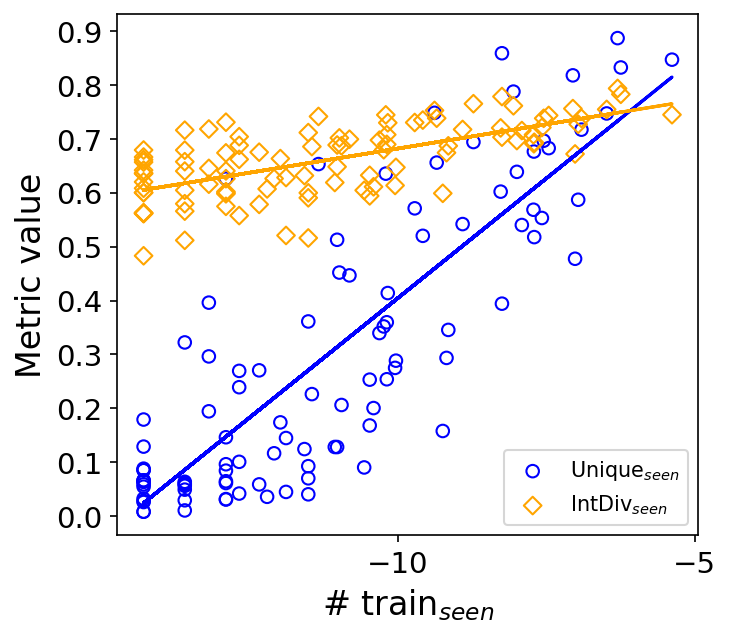

In [ ]:
x = np.log(train_sca_ratio)
y1 = train_met['unique']
y2 = train_met['intDiv']


plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(x, y1, label=r'Unique$_{seen}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(x, y2, label=r'IntDiv$_{seen}$', marker='D', facecolors='none', edgecolors='orange')
# plt.scatter(hac2, unique2, label=r'Unique$_{unseen}$', marker='^', facecolors='none', edgecolors='purple')
# plt.scatter(hac2, intdiv2, label=r'IntDiv$_{unseen}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel(r'# train$_{seen}$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(np.arange(-15, 5+1, 5), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower right')

m1, b1 = np.polyfit(x, y1, deg=1)
m2, b2 = np.polyfit(x, y2, deg=1)
plt.plot(x, m1*np.array(x) + b1, color='blue')
plt.plot(x, m2*np.array(x) + b2, color='orange')

plt.show()

### unique, intDiv vs. # scaffold test

In [ ]:
met1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf1-warmup15000-15/test_scaffolds/metric.csv', index_col=[0])
met2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf2-warmup15000-16/test_scaffolds/metric.csv', index_col=[0])
met3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/scavaetf3-warmup15000-16/test_scaffolds/metric.csv', index_col=[0])

num_cols = met1.select_dtypes(include='number').columns

test_met = (met1[num_cols] + met2[num_cols] + met3[num_cols]) / 3
test_met.head()

,valid,unique,novel,intDiv,sim,SSF,sim80,n_valid,n_unique,n_novel,n_SSF,n_sim80
0,0.997767,0.241470,0.998179,0.632228,0.997729,0.994320,0.994420,9977.666667,2409.333333,2405.000000,9921.000000,9922.000000
1,0.981267,0.155435,0.999282,0.670588,0.954851,0.856444,0.910471,9812.666667,1520.333333,1519.333333,8413.000000,8939.333333
2,0.996200,0.642238,0.997800,0.713741,0.979842,0.948802,0.950040,9962.000000,6398.000000,6384.000000,9451.666667,9464.000000
3,0.992933,0.083673,0.997340,0.611511,0.987717,0.973045,0.975026,9929.333333,830.666667,828.333333,9661.666667,9681.333333
4,0.997400,0.027104,1.000000,0.527115,0.992182,0.977104,0.977505,9974.000000,270.333333,270.333333,9745.666667,9749.666667


In [ ]:
# # train = train[:2000]
test = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/test_scaffolds.csv', index_col=[0])
test = test.dropna(subset=['scaffold'])

# freq = test['scaffold'].value_counts()
# with Pool(n_jobs=16) as pool:
#     mols = pool.map(mol_from_smiles, freq.index)
# with Pool(n_jobs=16) as pool:
#     hac = pool.map(HAC, mols)
            
# df = pd.DataFrame({
#     'scaffold': freq.index,
#     'HAC': hac,
#     'Frequency': freq.values
# })

# df.head()

In [ ]:
test_sca_frequency = [len(test[test.scaffold == sca]) for sca in met1['scaffold']]
test_sca_ratio = np.array(test_sca_frequency) / len(test)

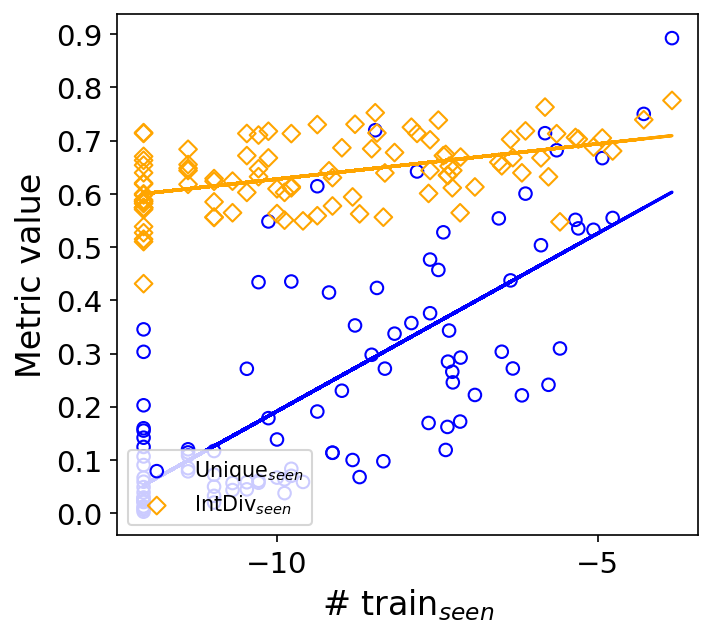

In [ ]:
x = np.log(test_sca_ratio)
y1 = test_met['unique']
y2 = test_met['intDiv']

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(x, y1, label=r'Unique$_{seen}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(x, y2, label=r'IntDiv$_{seen}$', marker='D', facecolors='none', edgecolors='orange')
# plt.scatter(hac2, unique2, label=r'Unique$_{unseen}$', marker='^', facecolors='none', edgecolors='purple')
# plt.scatter(hac2, intdiv2, label=r'IntDiv$_{unseen}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel(r'# train$_{seen}$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(np.arange(-15, 5+1, 5), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower left')

m1, b1 = np.polyfit(x, y1, deg=1)
m2, b2 = np.polyfit(x, y2, deg=1)
plt.plot(x, m1*np.array(x) + b1, color='blue')
plt.plot(x, m2*np.array(x) + b2, color='orange')

plt.show()

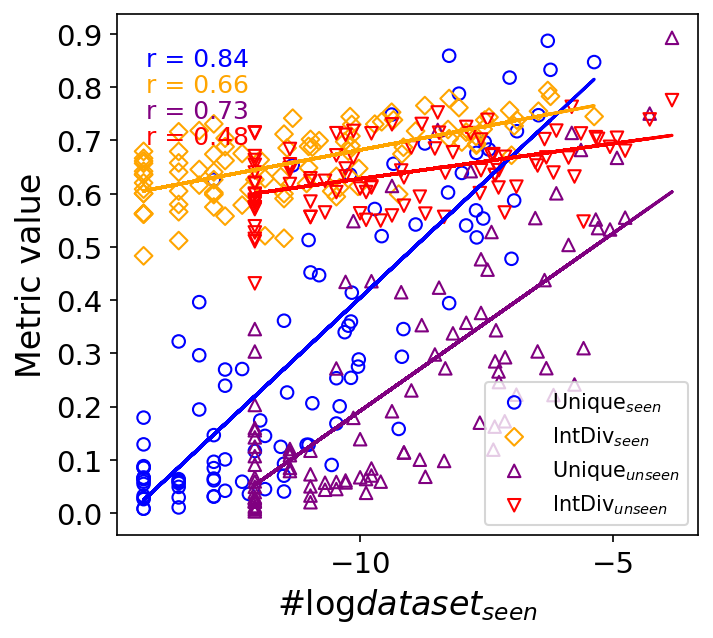

In [ ]:
# base = 10

x1 = np.log(train_sca_ratio)# / np.log(base)
x2 = np.log(test_sca_ratio)# / np.log(base)

# x1 = train_sca_ratio
# x2 = test_sca_ratio

y1_unique = train_met['unique']
y1_intdiv = train_met['intDiv']

y2_unique = test_met['unique']
y2_intdiv = test_met['intDiv']


plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(x1, y1_unique, label=r'Unique$_{seen}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(x1, y1_intdiv, label=r'IntDiv$_{seen}$', marker='D', facecolors='none', edgecolors='orange')

plt.scatter(x2, y2_unique, label=r'Unique$_{unseen}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(x2, y2_intdiv, label=r'IntDiv$_{unseen}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel(r'$\log(\text{dataset}_{\text{seen}})$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(np.arange(-15, 5+1, 5), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower right')

m1, b1 = np.polyfit(x1, y1_unique, deg=1)
m2, b2 = np.polyfit(x1, y1_intdiv, deg=1)
plt.plot(x1, m1*np.array(x1) + b1, color='blue')
plt.plot(x1, m2*np.array(x1) + b2, color='orange')
m1, b1 = np.polyfit(x2, y2_unique, deg=1)
m2, b2 = np.polyfit(x2, y2_intdiv, deg=1)
plt.plot(x2, m1*np.array(x2) + b1, color='purple')
plt.plot(x2, m2*np.array(x2) + b2, color='red')

# r1_unique = np.corrcoef(x1, y1_unique)[0, 1]
# r1_intdiv = np.corrcoef(x1, y1_intdiv)[0, 1]
# r2_unique = np.corrcoef(x2, y2_unique)[0, 1]
# r2_intdiv = np.corrcoef(x2, y2_intdiv)[0, 1]

# plt.text(0.05, 0.9, rf'r = {r1_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
# plt.text(0.05, 0.85, rf'r = {r1_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='orange')
# plt.text(0.05, 0.8, rf'r = {r2_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='purple')
# plt.text(0.05, 0.75, rf'r = {r2_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')

plt.show()

### 和 Train 比較

In [ ]:
train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])
train = train.dropna(subset=['scaffold'])

In [ ]:
# train = train[:2000]

In [ ]:
from pathos.multiprocessing import ProcessingPool as Pool
from rdkit.Chem import MolFromSmiles

def mol_from_smiles(smiles):
    return MolFromSmiles(smiles)

freq1 = train['scaffold'].value_counts()

with Pool(n_jobs=16) as pool:
    mols = pool.map(mol_from_smiles, freq1.index)
with Pool(n_jobs=16) as pool:
    hac = pool.map(HAC, mols)
            
df1 = pd.DataFrame({ 'HAC': hac, 'Frequency': freq1 })

In [ ]:
freq2 = df1['HAC'].value_counts()
df2 = pd.DataFrame({ 'HAC': freq2.index, 'Frequency': freq2.values })
df2 = df2.sort_values(by=['HAC'])

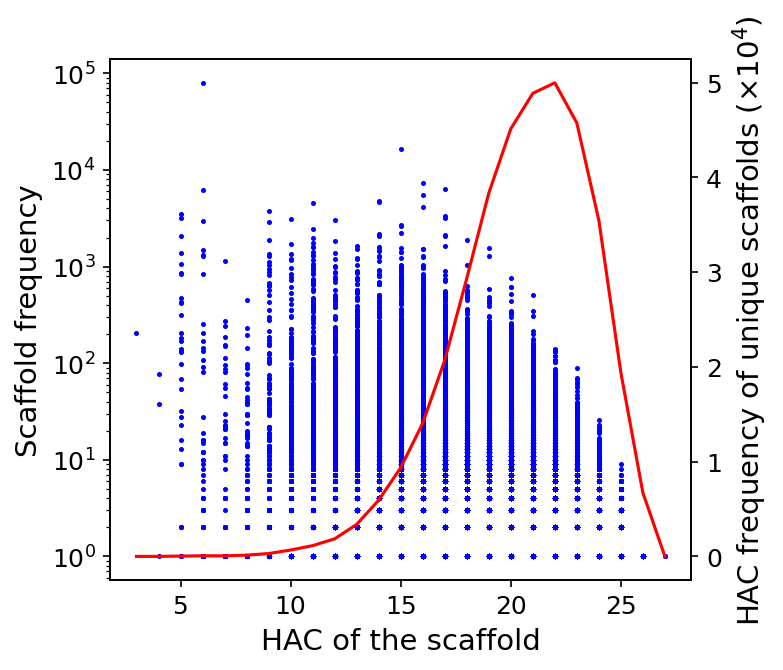

In [ ]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(figsize=(5, 4.6), dpi=150)

ax1.scatter(df1['HAC'], df1['Frequency'], color='blue', s=2, marker='o')
ax1.set_xlabel('HAC of the scaffold', fontsize=14)
ax1.set_ylabel('Scaffold frequency', fontsize=14)
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(df2['HAC'], df2['Frequency'] / 10000, color='red')
ax2.set_ylabel(r'HAC frequency of unique scaffolds ($\times 10^4$)', fontsize=14)
# ax2.set_yscale('log')

# plt.scatter(df['HAC of scaffolds'], df['Frequency (train)'], s=2, color='blue', marker='o')

# plt.xlabel('HAC of the scaffold', fontsize=16)
# plt.ylabel('Frequency in the train set', fontsize=16)

# plt.xticks(np.arange(0, 25+1, 5), fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.show()

### HAC(scaffold) / HAC(molecule)

In [ ]:
train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])
train = train.dropna(subset=['scaffold'])

In [ ]:
train = train[:200000]

In [ ]:
from pathos.multiprocessing import ProcessingPool as Pool
from rdkit.Chem import MolFromSmiles

def mol_from_smiles(smiles):
    return MolFromSmiles(smiles)

with Pool(n_jobs=16) as pool:
    mols = pool.map(mol_from_smiles, train['smiles'])
with Pool(n_jobs=16) as pool:
    train[r'$HAC_{smiles}$'] = pool.map(HAC, mols)

with Pool(n_jobs=16) as pool:
    mols = pool.map(mol_from_smiles, train['scaffold'])
with Pool(n_jobs=16) as pool:
    train[r'$HAC_{scaffold}$'] = pool.map(HAC, mols)

In [ ]:
train[r'$HAC_{scaffold}/HAC_{molecule}$'] = train[r'$HAC_{scaffold}$'] / train[r'$HAC_{smiles}$']

<AxesSubplot:xlabel='$HAC_{smiles}$', ylabel='$HAC_{scaffold}/HAC_{molecule}$'>

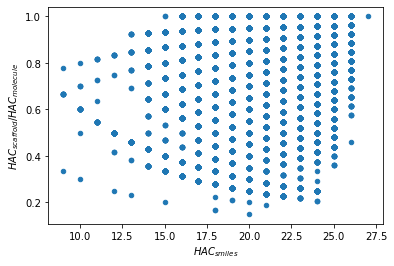

In [ ]:
train.plot.scatter(x=r'$HAC_{smiles}$',
                   y=r'$HAC_{scaffold}/HAC_{molecule}$')


### Show generated molecules of unseen scaffolds

In [9]:
file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/sca_sampling/'

In [10]:
testsca = pd.read_csv(os.path.join(file_folder, 'test_scaffolds_sample.csv'), index_col=[0])
mols = list(map(MolFromSmiles, testsca['scaffold']))
testsca['HAC'] = list(map(HAC, mols))

In [11]:
max_hac_sca = testsca[testsca.HAC == testsca['HAC'].max()]
min_hac_sca = testsca[testsca.HAC == testsca['HAC'].min()]

In [12]:
print(max_hac_sca)
print(min_hac_sca)

                                   scaffold  HAC
9  O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1   26
           scaffold  HAC
67  c1ccc2c(c1)CCS2    9


In [13]:
def get_gen_by_sid(sid):
    df1 = pd.read_csv(os.path.join(file_folder, f'scavaetf1-warmup15000-15/test_scaffolds/s{sid}_gen.csv'), index_col=[0])
    df2 = pd.read_csv(os.path.join(file_folder, f'scavaetf2-warmup15000-16/test_scaffolds/s{sid}_gen.csv'), index_col=[0])
    df3 = pd.read_csv(os.path.join(file_folder, f'scavaetf3-warmup15000-16/test_scaffolds/s{sid}_gen.csv'), index_col=[0])
    df = pd.concat([df1, df2, df3], axis=0).reset_index(drop=True)
    return df

def get_unique_compliant_gen(df, scaffold):
    df = df.drop_duplicates(subset='smiles')
    df['scaffold'] = df['smiles'].apply(lambda x: murcko_scaffold(x))
    df = df[df.scaffold == scaffold]
    df = df.reset_index(drop=True)
    return df


In [14]:
max_gen = get_gen_by_sid(max_hac_sca.index[0])
max_gen_found = get_unique_compliant_gen(max_gen, max_hac_sca['scaffold'].iloc[0])

min_gen = get_gen_by_sid(min_hac_sca.index[0])
min_gen_found = get_unique_compliant_gen(min_gen, min_hac_sca['scaffold'].iloc[0])

<ipython-input-13-9dfa43132814>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaffold'] = df['smiles'].apply(lambda x: murcko_scaffold(x))
<ipython-input-13-9dfa43132814>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaffold'] = df['smiles'].apply(lambda x: murcko_scaffold(x))


In [15]:
min_gen_found

,smiles,scaffold
0,COCCCNC(=O)NC1CSc2ccc(Cl)cc21,c1ccc2c(c1)CCS2
1,CCC(CC)NC(=O)NCC1CSc2ccc(F)cc21,c1ccc2c(c1)CCS2
2,CC(C)CCNC(=O)C1(C)CSc2ccccc21,c1ccc2c(c1)CCS2
3,CCN(CC)C(=O)NC1CSc2ccc(C(=O)NCCO)cc21,c1ccc2c(c1)CCS2
4,CC(C)(C)C(=O)NC1CSc2ccc(C(F)(F)F)cc21,c1ccc2c(c1)CCS2
...,...,...
15980,CC(C)CNC(=O)CCCC(=O)NC1CSc2c(F)cccc21,c1ccc2c(c1)CCS2
15981,CCCNC(=O)N(CCO)C1CSc2ccccc21,c1ccc2c(c1)CCS2
15982,CCC(NC(=O)CNC(N)=O)C1CSc2ccc(Br)cc21,c1ccc2c(c1)CCS2
15983,COc1ccc2c(c1)SCC2CNS(=O)(=O)N(C)C,c1ccc2c(c1)CCS2


In [16]:
scaffold = min_hac_sca['scaffold'].iloc[0]
smiles = min_gen_found.loc[:15, 'smiles']

print(len(smiles))

plot_highlighted_smiles_group(
    smiles=smiles,
    img_size=(500, 300),
    substructure_smiles=scaffold,
    save_path='uc-small.png',
    n_per_mol=4
)

16


NameError: name 'plot_highlighted_smiles_group' is not defined

In [ ]:
scaffold = max_hac_sca['scaffold'].iloc[0]
smiles = max_gen_found.loc[:15, 'smiles']

print(len(smiles))

plot_highlighted_smiles_group(
    smiles=smiles,
    img_size=(500, 300),
    substructure_smiles=scaffold,
    save_path='uc-big.png',
    n_per_mol=4
)

16
16


In [ ]:
print('min scaffold condition:', min_hac_sca['scaffold'].iloc[0])
print('max scaffold condition:', max_hac_sca['scaffold'].iloc[0])

min scaffold condition: c1ccc2c(c1)CCS2
max scaffold condition: O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1


In [20]:
def get_gen_metric(data_type='test_scaffolds'):
    df1 = pd.read_csv(os.path.join(file_folder, f'scavaetf1-warmup15000-15/{data_type}/metric.csv'), index_col=[0])
    df2 = pd.read_csv(os.path.join(file_folder, f'scavaetf2-warmup15000-16/{data_type}/metric.csv'), index_col=[0])
    df3 = pd.read_csv(os.path.join(file_folder, f'scavaetf3-warmup15000-16/{data_type}/metric.csv'), index_col=[0])
    scaffold = df1['scaffold']
    del df1['scaffold']
    del df2['scaffold']
    del df3['scaffold']
    df = (df1 + df2 + df3) / 3
    df.insert(0, 'scaffold', scaffold)
    return df

In [ ]:
df = get_gen_metric()

In [17]:
print(df.iloc[min_hac_sca.index[0]])

scaffold               c1ccc2c(c1)CCS2
valid                         0.995233
unique                        0.719694
novel                         0.995337
intDiv                        0.752571
sim                           0.961424
SSF                           0.902218
sim80                         0.902218
n_valid                    9952.333333
n_unique                   7162.666667
n_novel                    7129.333333
n_SSF                           8979.0
n_sim80                         8979.0
n_unique_ssf                    6318.0
valid_in_tolerance              8979.0
unique_in_tolerance             6318.0
Name: 67, dtype: object


In [19]:
df.sort_values('unique_in_tolerance', ascending=False)

,scaffold,valid,unique,novel,intDiv,sim,SSF,sim80,n_valid,n_unique,n_novel,n_SSF,n_sim80,n_unique_ssf,valid_in_tolerance,unique_in_tolerance
76,c1ccc2ncccc2c1,0.990167,0.892773,0.999096,0.775696,0.975656,0.935587,0.938178,9901.666667,8840.000000,8832.000000,9263.000000,9288.666667,8217.000000,9263.000000,8217.000000
31,c1ccc(-c2cscn2)cc1,0.993533,0.750394,0.998253,0.739469,0.990044,0.980502,0.980502,9935.333333,7455.666667,7442.666667,9741.666667,9741.666667,7264.666667,9741.666667,7264.666667
74,c1ccc(C2CCCC2)cc1,0.997200,0.714149,0.998739,0.763158,0.992226,0.978403,0.981548,9972.000000,7121.666667,7112.666667,9756.333333,9787.666667,6911.666667,9756.333333,6911.666667
27,O=C(Nc1ccccc1)c1cncnc1,0.997633,0.682076,0.999455,0.713190,0.994122,0.986267,0.986367,9976.333333,6804.666667,6801.000000,9839.000000,9840.000000,6668.666667,9839.000000,6668.666667
29,O=C(NCCc1ccccc1)Nc1ccccc1,0.998500,0.667299,0.994635,0.705049,0.989065,0.974128,0.974295,9985.000000,6663.000000,6627.333333,9726.666667,9728.333333,6412.333333,9726.666667,6412.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,O=C(NCc1cscn1)N1CCCC1c1nc2ccccc2[nH]1,0.957767,0.009968,1.000000,0.510458,0.992632,0.926784,0.998017,9577.666667,95.666667,95.666667,8902.333333,9558.666667,66.333333,8902.333333,66.333333
13,O=C1CCc2cc(NC(=O)N3CCOCC3C3CC3)ccc2N1,0.990533,0.029301,0.992844,0.620507,0.956732,0.816355,0.836896,9905.333333,289.333333,287.666667,8087.000000,8291.000000,50.000000,8087.000000,50.000000
9,O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1,0.999500,0.003069,1.000000,0.431473,0.998948,0.996998,0.997064,9995.000000,30.666667,30.666667,9965.000000,9965.666667,21.333333,9965.000000,21.333333
87,O=C(c1cnccn1)N1CCN2CC(OCc3ccccc3)CC2C1,0.996600,0.303423,0.999440,0.586582,0.812202,0.661764,0.664966,9966.000000,3006.000000,3001.000000,6615.000000,6647.000000,15.333333,6615.000000,15.333333


In [22]:
train_results = get_gen_metric('train')
train_results.sort_values('unique_in_tolerance', ascending=False)

,scaffold,valid,unique,novel,intDiv,sim,SSF,sim80,n_valid,n_unique,n_novel,n_SSF,n_sim80,n_unique_ssf,valid_in_tolerance,unique_in_tolerance
59,c1ccc2[nH]ccc2c1,0.986133,0.887155,0.948074,0.793768,0.995148,0.990295,0.991006,9861.333333,8748.333333,8294.333333,9763.666667,9770.666667,8650.666667,9763.666667,8650.666667
79,O=C(NCc1ccccc1)c1ccccc1,0.997867,0.847172,0.830803,0.744983,0.992146,0.985602,0.985636,9978.666667,8453.666667,7024.000000,9835.000000,9835.333333,8311.333333,9835.000000,8311.333333
33,C1CCNC1,0.993400,0.859070,0.983717,0.778703,0.980112,0.966608,0.966608,9934.000000,8534.000000,8395.000000,9600.666667,9600.666667,8203.666667,9600.666667,8203.666667
76,c1ccc2c(c1)CCNC2,0.993167,0.832659,0.921854,0.782883,0.995854,0.990299,0.990333,9931.666667,8269.666667,7623.666667,9834.333333,9834.666667,8172.333333,9834.333333,8172.333333
75,c1ccc(Cn2cccn2)cc1,0.994833,0.818038,0.953030,0.756350,0.989830,0.982335,0.982369,9948.333333,8138.000000,7756.000000,9772.666667,9773.000000,7964.333333,9772.666667,7964.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,O=C1CCc2cc(NC(=O)C3CC4C=CC3C4)ccc2N1,0.974900,0.060966,0.995533,0.679240,0.971634,0.891522,0.935146,9749.000000,591.333333,589.000000,8696.000000,9119.000000,134.000000,8696.000000,134.000000
67,O=C(c1ccc(NC2CC2)nc1)N(CC1CCCCC1)C1CC1,0.993233,0.032411,0.996621,0.600360,0.965044,0.818083,0.951432,9932.333333,321.666667,320.666667,8127.666667,9450.666667,83.666667,8127.666667,83.666667
62,O=C(Nc1nccs1)N1CCC(c2nc3ccccc3o2)CC1,0.998200,0.010519,0.980878,0.511847,0.994976,0.987544,0.988045,9982.000000,105.000000,103.000000,9857.666667,9862.666667,65.000000,9857.666667,65.000000
57,O=C(C1CCCN1c1nc2ccccc2o1)N1CCc2ccccc21,0.998800,0.008177,0.987533,0.483176,0.997762,0.990588,0.994560,9988.000000,81.666667,80.666667,9894.000000,9933.666667,48.333333,9894.000000,48.333333
